# Irradiance Data From NREL NSRDB
---
**NREL**: National Renewable Energy Laboratory (NREL)  

**NSRDB**: National Solar Radiation Database  
Information can be found at https://nsrdb.nrel.gov  
API: https://developer.nrel.gov/docs/solar/nsrdb/psm3_data_download/

**SAM**: System Advisor Model from NREL  
Information can be found at https://sam.nrel.gov/  
SDK: https://sam.nrel.gov/sdk  
Patch: https://github.com/sjschneider/py3samsdk

The NSRDB is a serially complete collection of meteorological and solar irradiance data sets for the United States. A physics-based modeling (PSM: Physical Solar Model) approach that provides solar radiation data for the entire United States in gridded segments (4 km x 4 km) using geostationary satellites is used.

## 1. Sites location
The location (longitude and latitude) of the solar plant in the Western grid are chosen.

In [1]:
import westernintnet
grid = westernintnet.WesternIntNet()

Loading sub
Loading bus2sub
Loading bus
Loading genbus
Loading branches
Done loading


In [2]:
solar_plant = grid.genbus.groupby('type').get_group('solar')

In [3]:
print("There are %d solar plants in the Western grid." % len(solar_plant))
solar_plant.head(n=10)

There are 391 solar plants in the Western grid.


,busID,Pg,Qg,Qmax,Qmin,Vg,mBase,status,Pmax,Pmin,...,ramp_q,apf,mu_Pmax,mu_Pmin,mu_Qmax,mu_Qmin,type,lat,lon,base_color
51,10760,0.00,0.0,0.0,0.0,1.0400,69.12,0,61.50,13.06,...,0,61.5000,0.0,0.0,0.0,0.0000;,solar,45.584722,-122.405600,#feb308
57,10776,0.00,0.0,0.0,0.0,1.0318,32.07,0,28.00,3.77,...,0,28.0000,0.0,0.0,0.0,0.0000;,solar,48.448100,-122.433100,#feb308
58,10776,14.32,0.0,0.0,0.0,1.0318,23.98,1,14.32,14.32,...,0,20.0000,0.0,0.0,0.0,0.0000;,solar,48.448100,-122.433100,#feb308
61,10782,13.43,0.0,0.0,0.0,1.0162,27.32,1,13.43,13.43,...,0,18.3333,0.0,0.0,0.0,0.0000;,solar,46.103887,-122.918429,#feb308
62,10782,14.65,0.0,0.0,0.0,1.0162,18.63,1,14.65,14.65,...,0,18.3333,0.0,0.0,0.0,0.0000;,solar,46.103887,-122.918429,#feb308
63,10783,13.24,0.0,0.0,0.0,1.0155,22.11,1,13.24,13.24,...,0,18.3333,0.0,0.0,0.0,0.0000;,solar,46.103887,-122.918429,#feb308
64,10784,17.21,0.0,0.0,0.0,1.0192,43.83,1,17.21,17.21,...,0,39.4000,0.0,0.0,0.0,0.0000;,solar,48.746000,-122.486000,#feb308
65,10784,42.83,0.0,0.0,0.0,1.0192,64.64,1,42.83,42.83,...,0,58.2000,0.0,0.0,0.0,0.0000;,solar,48.746000,-122.486000,#feb308
66,10785,39.40,0.0,0.0,0.0,1.0192,44.46,1,39.40,39.40,...,0,39.4000,0.0,0.0,0.0,0.0000;,solar,48.746000,-122.486000,#feb308
67,10785,31.08,0.0,0.0,0.0,1.0192,49.64,1,31.08,31.08,...,0,39.4000,0.0,0.0,0.0,0.0000;,solar,48.746000,-122.486000,#feb308


Note that that multiple solar plants can share the same location. The reason is that portions of the same plant can differ by their technology and, consequently, have different output power (Pmax). A dictionary where the keys are the coordinates and the values are the indices of the plants is creqted below.

In [4]:
coord = {}
for i in range(len(solar_plant)):
    key = (solar_plant.lon.values[i],solar_plant.lat.values[i])
    if key not in coord.keys():
        coord[key] = [(solar_plant.index[i],solar_plant.Pmax.values[i])]
    else:
        coord[key].append((solar_plant.index[i],solar_plant.Pmax.values[i]))
print("There are %d unique locations." % len(coord))

There are 150 unique locations.


## 2. Irradiance Data

In [5]:
import pandas as pd
import random

The Physical Solar Model (PSM) v3 API is used to collect and download, as CSV, a configurable set of solar and meteoroligical data fields from The NSRDB.

In [6]:
# api key
api_key = '0neC1BX0VMIGFJWIXYA7Y9ZCjbmHeceLHjWiPjdf'

# year
year, leap_year = 2016, 'false'

# Set the attributes to extract
attributes = 'ghi,dhi,dni,wind_speed,air_temperature,solar_zenith_angle'

# Set time interval in minutes, i.e., '30' is half hour intervals.
# Valid intervals are 30 & 60.
interval = '60'

# Specify Coordinated Universal Time (UTC), 'true' will use UTC, 'false' will
# use the local time zone of the data. NOTE: In order to use the NSRDB data in
# SAM, you must specify UTC as 'false'. SAM requires the data to be in the
# local time zone.
utc = 'false'

# Full name
name = 'Benjamin+Rouille+d+Orfeuil'

# Reason for using the NSRDB.
reason = 'Renewable+Energy+Studies'

# Affiliation
affiliation = 'Intellectual+Ventures'

# Email address
email = 'brdo@intven.com'

# Mailing list subscription
list = 'false'

The url containing all the relevant information is constructed.

In [7]:
url = 'http://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv?'
url = url + 'api_key={key}'.format(key=api_key)

payload = 'names={year}'.format(year=year) + '&' + \
          'leap_day={leap}'.format(leap=leap_year) + '&' + \
          'interval={interval}'.format(interval=interval) + '&' + \
          'utc={utc}'.format(utc=utc) + '&' + \
          'full_name={name}'.format(name=name) + '&' + \
          'email={email}'.format(email=email) + '&' + \
          'affiliation={affiliation}'.format(affiliation=affiliation) + '&' + \
          'mailing_list={mailing_list}'.format(mailing_list=list) + '&' + \
          'reason={reason}'.format(reason=reason) + '&' + \
          'attributes={attr}'.format(attr=attributes)

One site is picked randomly among all the solar plants location.

In [8]:
import random

site = random.choice(coord.keys())
print("Site location: (%.3f, %.3f)" % (site[0], site[1]))

Site location: (-118.505, 34.789)


Data are loaded in a data frame.

In [9]:
query = 'wkt=POINT({lon}%20{lat})'.format(lon=str(site[0]), lat=str(site[1]))

info = pd.read_csv(url+'&'+payload+'&'+query, nrows=1)
timezone, elevation = info['Local Time Zone'], info['Elevation']

data = pd.read_csv(url+'&'+payload+'&'+query, skiprows=2)

In [10]:
data = data.set_index(pd.date_range(start='1/1/{yr}'.format(yr=year), freq='H', periods=365*24*60/int(interval)))

In [11]:
data.head()

,Year,Month,Day,Hour,Minute,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
2016-01-01 00:00:00,2016,1,1,0,30,0,0,0,4.2,-1,166.26
2016-01-01 01:00:00,2016,1,1,1,30,0,0,0,4.3,-1,156.64
2016-01-01 02:00:00,2016,1,1,2,30,0,0,0,4.6,-1,144.82
2016-01-01 03:00:00,2016,1,1,3,30,0,0,0,4.6,-1,132.54
2016-01-01 04:00:00,2016,1,1,4,30,0,0,0,4.5,-1,120.27


## 3. SAM
The solar and meteoroligical data collected from the NSRDB as weel as some variables defining the system configuration are used to construct a SSC (SAM Simulation Core) object.

In [12]:
from py3samsdk import PySSC

ssc_lib = 'U:\\SAM\\2017-9-5-r4\\win64\\'
ssc = PySSC(ssc_lib)

In [13]:
# Resource inputs for SAM model:
SAM_resource = ssc.data_create()
ssc.data_set_number(SAM_resource, 'lat', site[1])
ssc.data_set_number(SAM_resource, 'lon', site[0])
ssc.data_set_number(SAM_resource, 'tz', timezone)
ssc.data_set_number(SAM_resource, 'elev', elevation)
ssc.data_set_array(SAM_resource, 'year', data.index.year)
ssc.data_set_array(SAM_resource, 'month', data.index.month)
ssc.data_set_array(SAM_resource, 'day', data.index.day)
ssc.data_set_array(SAM_resource, 'hour', data.index.hour)
ssc.data_set_array(SAM_resource, 'minute', data.index.minute)
ssc.data_set_array(SAM_resource, 'dn', data['DNI'])
ssc.data_set_array(SAM_resource, 'df', data['DHI'])
ssc.data_set_array(SAM_resource, 'wspd', data['Wind Speed'])
ssc.data_set_array(SAM_resource, 'tdry', data['Temperature'])

# Create SAM compliant object  
SAM_core = ssc.data_create()
ssc.data_set_table(SAM_core, 'solar_resource_data', SAM_resource)
ssc.data_free(SAM_resource)

# Specify the system Configuration
# Set system capacity in MW
system_capacity = coord[(site[0],site[1])][0][1]
ssc.data_set_number(SAM_core, 'system_capacity', system_capacity)
# Set DC/AC ratio (or power ratio). See 
# https://sam.nrel.gov/sites/default/files/content/virtual_conf_july_2013/07-sam-virtual-conference-2013-woodcock.pdf
ssc.data_set_number(SAM_core, 'dc_ac_ratio', 1.1)
# Set tilt of system in degrees
ssc.data_set_number(SAM_core, 'tilt', 25)
# Set azimuth angle (in degrees) from north (0 degrees)
ssc.data_set_number(SAM_core, 'azimuth', 180)
# Set the inverter efficency
ssc.data_set_number(SAM_core, 'inv_eff', 96)
# Set the system losses, in percent
ssc.data_set_number(SAM_core, 'losses', 14.0757)
# Specify fixed tilt system (0=Fixed, 1=Fixed Roof, 2=1 Axis Tracker, 3=Backtracted, 4=2 Axis Tracker)
ssc.data_set_number(SAM_core, 'array_type', 0)
# Set ground coverage ratio
ssc.data_set_number(SAM_core, 'gcr', 0.4)
# Set constant loss adjustment
ssc.data_set_number(SAM_core, 'adjust:constant', 0)

The solar power output can now be generated. The results are added to the original dataset.

In [14]:
import numpy as np

mod = ssc.module_create('pvwattsv5')
ssc.module_exec(mod, SAM_core)
data['Pout'] = np.array(ssc.data_get_array(SAM_core, 'gen'))

# free the memory
ssc.data_free(SAM_core)
ssc.module_free(mod)

The irrdiance data along with the solar power output are plotted for comparison. The naive calculation of the solar power output (see [`naive.py`](naive.py)) is also included.

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

def nsrdb_plot(df, i):
    var = ['GHI','DNI','DHI','Solar Zenith Angle','90 Degree Zenith']
    style = {'90 Degree Zenith':'--y','Solar Zenith Angle':'-o','DNI':'-o','DHI':'-o','GHI':'-'}
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    df['90 Degree Zenith'] = 90
    df['naive Pout'] = system_capacity*data['GHI']/data['GHI'].max()

    df[var][i:i+24].plot(ax=ax, figsize=(15,8), style=style, legend=False)
    df[['Pout','naive Pout']][i:i+24].plot(ax=ax2, style={'Pout':'m-o', 'naive Pout':'mo'})
    
    ax.grid()
    ax.set_ylabel('W/m2')
    ax2.set_ylabel('MW')
    ax.legend(loc=2, ncol=5, frameon=False)
    ax2.legend(loc=1, frameon=False)

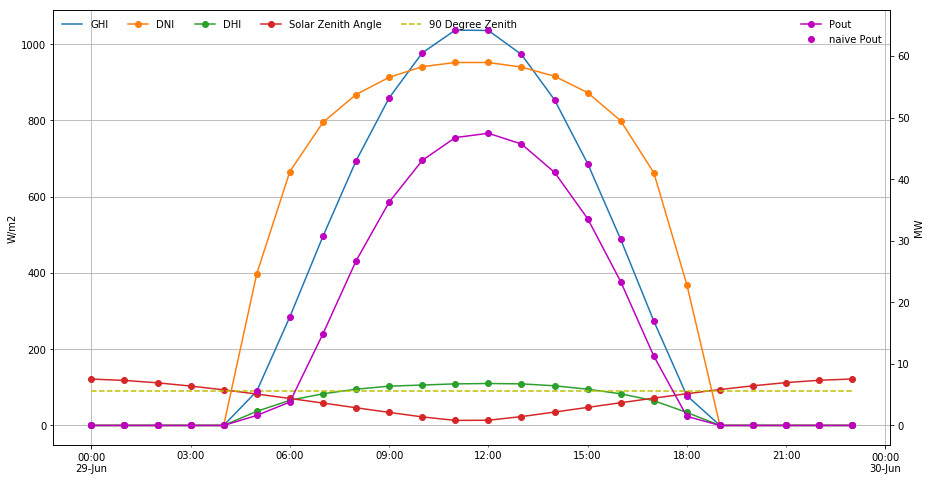

In [16]:
nsrdb_plot(data, 4320)

The capacity of the chosen plant, i.e., the unitless ratio of an actual electrical power output over a given period of time to the maximum possible electrical power output over that period is given below.

In [17]:
print("Capacity Factor: %.3f" % (data['Pout'].sum() / (365*24*60/int(interval) * system_capacity)))

Capacity Factor: 0.207


The total solar power out over the given period is:

In [18]:
print("Total power produced: %d MW" % data['Pout'].sum())

Total power produced: 119414 MW
